In [3]:
from pheno_clean_funcs import AddFileNames
import os
import re
from PIL import Image
import nibabel as nib

## Phenotypic Data CSV cleaning
Phenotypic data is stored in a csv file, that requires pre-processing, for ease of reference I shall add filenames of extracted
data, into columns, and deal with any missing data.

### Raw phenotypic data

Make object containing the raw dataframe, this object instance can be worked on to produce final output, new features can be added based on extracted data.

In [55]:
raw = AddFileNames('Phenotypic_V1_0b_preprocessed.csv', 'phenotype_files')

In [56]:
raw_df = raw.df

In [57]:
raw_df.head() # at this stage only the subject identification features and  diagnosis classes are needed.

,Unnamed: 0,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,...,qc_rater_1,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3
0,1,50002,1,50002,PITT,no_filename,1,1,16.77,1,...,fail,NaN,OK,NaN,fail,ic-parietal-cerebellum,OK,NaN,fail,ERROR #24
1,2,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,1,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN
2,3,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,1,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN
3,4,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,2,...,OK,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN
4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,1,...,OK,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN


In [58]:
st1_df = raw_df[['SITE_ID','X','SUB_ID','FILE_ID','AGE_AT_SCAN','SEX','DSM_IV_TR','DX_GROUP']] # extract necessary data

In [61]:
raw.update_df(st1_df) # update object instant dataframe with new df

In [70]:
stage_1 = raw.df # store updated df in new variable

## Adding FMRI filenames and updating File_ID field
File_ID data is neccesary  for data analysis since its an identifier for any data on a subject, and this field contains missing values. these missing values can be imputed using the fMRi data filenames.

In [63]:
fMRI_dir = os.path.join(os.getcwd(), 'func_ABIDE') # subdirectory containing fMRI data

In [66]:
fMRI_files= next(os.walk(func_repo))[2] # acquire all fMRI files
fMRI_files = [fMRI_files[i] for i in range(len(fMRI_files)) if 'nii.gz' in fMRI_files[i]] # limit to nifti files

In [68]:
print(f' Number of fMRI files : {len(fMRI_files)} \n Number of rows in phenotypic file: {len(stage_1)}')

 Number of fMRI files : 1102 
 Number of rows in phenotypic file: 1112


There are more subjects in the raw phenotypic data than there are fMRI files, these missing data pertains to fMRI scans that did not pass Quality control checks following preproccing in the CPAC pipeline. the subject with fMRI data will be removed.

In [74]:
present = [] # indexes of rows with a corresponding fMRI file
for i in range(len(fMRI_files)):
    here = re.search('5\d+\d', fMRI_files[i]).group() # use regex, every subject ID start with 5 following by unique digit combination
    present.append(int(here))

absent = [] # missing rows
for i in range(len(stage_1)):
    if stage_1.loc[i, 'SUB_ID'] not in present:
        absent.append(i)
len(stage_1) - len(absent) == len(fMRI_files)

True

In [78]:
stage_1.iloc[absent] # rows that did not pass quality control

,SITE_ID,X,SUB_ID,FILE_ID,AGE_AT_SCAN,SEX,DSM_IV_TR,DX_GROUP
909,UCLA_1,910,51232,no_filename,15.79,1,1,1
910,UCLA_1,911,51233,no_filename,12.75,1,1,1
919,UCLA_1,920,51242,no_filename,14.14,2,1,1
920,UCLA_1,921,51243,no_filename,11.69,1,1,1
921,UCLA_1,922,51244,no_filename,13.09,1,1,1
922,UCLA_1,923,51245,no_filename,14.98,1,1,1
923,UCLA_1,924,51246,no_filename,13.10,1,1,1
924,UCLA_1,925,51247,no_filename,11.97,1,1,1
947,UCLA_1,948,51270,no_filename,11.08,1,0,2
979,UCLA_2,980,51310,no_filename,11.70,1,0,2


In [79]:
stage_1.drop(absent,inplace = True) # drop all rows with missing data, inplace
stage_1.reset_index(drop= True,inplace = True) # reset index

/var/folders/0k/w62sf0c17hs15h730mmdkmj40000gn/T/ipykernel_94578/969473639.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stage_1.drop(absent,inplace = True)


In [80]:
raw.update_df(stage_1) # update object instance

In [86]:
len(raw.df) # it worked

1102

## Add column with fMRI data filenames

Before FILE_ID missing values can be imputed filenames from fMRI data must be added

In [85]:
raw.add_feature('FMRI_FILES', 'func_ABIDE', '.nii.gz') #use method `add_feature` to update class and add all filenames

/Users/admin/Documents/Project/pheno_clean_funcs.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,SITE_ID,X,SUB_ID,FILE_ID,AGE_AT_SCAN,SEX,DSM_IV_TR,DX_GROUP,FMRI_FILES
0,PITT,1,50002,no_filename,16.77,1,1,1,Pitt_0050002_func_preproc.nii.gz
1,PITT,2,50003,Pitt_0050003,24.45,1,1,1,Pitt_0050003_func_preproc.nii.gz
2,PITT,3,50004,Pitt_0050004,19.09,1,1,1,Pitt_0050004_func_preproc.nii.gz
3,PITT,4,50005,Pitt_0050005,13.73,2,1,1,Pitt_0050005_func_preproc.nii.gz
4,PITT,5,50006,Pitt_0050006,13.37,1,1,1,Pitt_0050006_func_preproc.nii.gz
...,...,...,...,...,...,...,...,...,...
1097,SBL,1108,51583,SBL_0051583,35.00,1,2,1,SBL_0051583_func_preproc.nii.gz
1098,SBL,1109,51584,SBL_0051584,49.00,1,2,1,SBL_0051584_func_preproc.nii.gz
1099,SBL,1110,51585,SBL_0051585,27.00,1,1,1,SBL_0051585_func_preproc.nii.gz
1100,MAX_MUN,1111,51606,MaxMun_a_0051606,29.00,2,2,1,MaxMun_a_0051606_func_preproc.nii.gz


In [87]:
stage_2 = raw.df

In [88]:
stage_2.head()

,SITE_ID,X,SUB_ID,FILE_ID,AGE_AT_SCAN,SEX,DSM_IV_TR,DX_GROUP,FMRI_FILES
0,PITT,1,50002,no_filename,16.77,1,1,1,Pitt_0050002_func_preproc.nii.gz
1,PITT,2,50003,Pitt_0050003,24.45,1,1,1,Pitt_0050003_func_preproc.nii.gz
2,PITT,3,50004,Pitt_0050004,19.09,1,1,1,Pitt_0050004_func_preproc.nii.gz
3,PITT,4,50005,Pitt_0050005,13.73,2,1,1,Pitt_0050005_func_preproc.nii.gz
4,PITT,5,50006,Pitt_0050006,13.37,1,1,1,Pitt_0050006_func_preproc.nii.gz


### Impute FILE_ID data

In [94]:
file_ids = stage_2['FILE_ID']

In [96]:
missing_index = []
for i,file in enumerate(file_ids):
    pattern = re.search('5\d+\d',file) # use regex to search if value contains a string matching subject id
    if pattern == None:
        missing_index.append(i)

In [102]:
stage_2.loc[missing_index,'FILE_ID'].unique() # all missing values designated as no_filename

array(['no_filename'], dtype=object)

In [103]:
len(missing_index)

67

In [105]:
stage_2.loc[missing_index,['FILE_ID', 'FMRI_FILES']] # all missing file_ids contain fmri filenames containg desired id

,FILE_ID,FMRI_FILES
0,no_filename,Pitt_0050002_func_preproc.nii.gz
63,no_filename,Olin_0050108_func_preproc.nii.gz
92,no_filename,Olin_0050137_func_preproc.nii.gz
104,no_filename,OHSU_0050155_func_preproc.nii.gz
114,no_filename,OHSU_0050165_func_preproc.nii.gz
...,...,...
1025,no_filename,MaxMun_a_0051367_func_preproc.nii.gz
1026,no_filename,MaxMun_a_0051368_func_preproc.nii.gz
1029,no_filename,MaxMun_a_0051371_func_preproc.nii.gz
1030,no_filename,MaxMun_a_0051372_func_preproc.nii.gz


In [107]:
for i in missing_index:
    correct_id = stage_2.loc[i,'FMRI_FILES'].replace('_func_preproc.nii.gz', '') # take subject id potion of the filenames
    stage_2.loc[i, 'FILE_ID'] = correct_id # change the file ids at indexes with missing values to correct id

In [109]:
stage_2.loc[missing_index] # it worked

,SITE_ID,X,SUB_ID,FILE_ID,AGE_AT_SCAN,SEX,DSM_IV_TR,DX_GROUP,FMRI_FILES
0,PITT,1,50002,Pitt_0050002,16.77,1,1,1,Pitt_0050002_func_preproc.nii.gz
63,OLIN,64,50108,Olin_0050108,21.00,1,0,2,Olin_0050108_func_preproc.nii.gz
92,OLIN,93,50137,Olin_0050137,20.00,1,0,1,Olin_0050137_func_preproc.nii.gz
104,OHSU,105,50155,OHSU_0050155,14.42,1,-9999,1,OHSU_0050155_func_preproc.nii.gz
114,OHSU,115,50165,OHSU_0050165,9.69,1,-9999,2,OHSU_0050165_func_preproc.nii.gz
...,...,...,...,...,...,...,...,...,...
1025,MAX_MUN,1036,51367,MaxMun_a_0051367,21.00,1,0,2,MaxMun_a_0051367_func_preproc.nii.gz
1026,MAX_MUN,1037,51368,MaxMun_a_0051368,28.00,2,0,2,MaxMun_a_0051368_func_preproc.nii.gz
1029,MAX_MUN,1040,51371,MaxMun_a_0051371,48.00,1,0,2,MaxMun_a_0051371_func_preproc.nii.gz
1030,MAX_MUN,1041,51372,MaxMun_a_0051372,46.00,2,0,2,MaxMun_a_0051372_func_preproc.nii.gz


In [110]:
raw.update_df(stage_2)

In [111]:
raw.df

,SITE_ID,X,SUB_ID,FILE_ID,AGE_AT_SCAN,SEX,DSM_IV_TR,DX_GROUP,FMRI_FILES
0,PITT,1,50002,Pitt_0050002,16.77,1,1,1,Pitt_0050002_func_preproc.nii.gz
1,PITT,2,50003,Pitt_0050003,24.45,1,1,1,Pitt_0050003_func_preproc.nii.gz
2,PITT,3,50004,Pitt_0050004,19.09,1,1,1,Pitt_0050004_func_preproc.nii.gz
3,PITT,4,50005,Pitt_0050005,13.73,2,1,1,Pitt_0050005_func_preproc.nii.gz
4,PITT,5,50006,Pitt_0050006,13.37,1,1,1,Pitt_0050006_func_preproc.nii.gz
...,...,...,...,...,...,...,...,...,...
1097,SBL,1108,51583,SBL_0051583,35.00,1,2,1,SBL_0051583_func_preproc.nii.gz
1098,SBL,1109,51584,SBL_0051584,49.00,1,2,1,SBL_0051584_func_preproc.nii.gz
1099,SBL,1110,51585,SBL_0051585,27.00,1,1,1,SBL_0051585_func_preproc.nii.gz
1100,MAX_MUN,1111,51606,MaxMun_a_0051606,29.00,2,2,1,MaxMun_a_0051606_func_preproc.nii.gz


## Adding filenames of CC200 atlas time series data
- subdirectory containing data: 'rois_cc200'
- feature name to be added to dataframe: 'CC200'
- file extension: '.1D'

In [112]:
raw.add_feature('CC200','rois_cc200', '.1D')

/Users/admin/Documents/Project/pheno_clean_funcs.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,SITE_ID,X,SUB_ID,FILE_ID,AGE_AT_SCAN,SEX,DSM_IV_TR,DX_GROUP,FMRI_FILES,CC200
0,PITT,1,50002,Pitt_0050002,16.77,1,1,1,Pitt_0050002_func_preproc.nii.gz,Pitt_0050002_rois_cc200.1D
1,PITT,2,50003,Pitt_0050003,24.45,1,1,1,Pitt_0050003_func_preproc.nii.gz,Pitt_0050003_rois_cc200.1D
2,PITT,3,50004,Pitt_0050004,19.09,1,1,1,Pitt_0050004_func_preproc.nii.gz,Pitt_0050004_rois_cc200.1D
3,PITT,4,50005,Pitt_0050005,13.73,2,1,1,Pitt_0050005_func_preproc.nii.gz,Pitt_0050005_rois_cc200.1D
4,PITT,5,50006,Pitt_0050006,13.37,1,1,1,Pitt_0050006_func_preproc.nii.gz,Pitt_0050006_rois_cc200.1D
...,...,...,...,...,...,...,...,...,...,...
1097,SBL,1108,51583,SBL_0051583,35.00,1,2,1,SBL_0051583_func_preproc.nii.gz,SBL_0051583_rois_cc200.1D
1098,SBL,1109,51584,SBL_0051584,49.00,1,2,1,SBL_0051584_func_preproc.nii.gz,SBL_0051584_rois_cc200.1D
1099,SBL,1110,51585,SBL_0051585,27.00,1,1,1,SBL_0051585_func_preproc.nii.gz,SBL_0051585_rois_cc200.1D
1100,MAX_MUN,1111,51606,MaxMun_a_0051606,29.00,2,2,1,MaxMun_a_0051606_func_preproc.nii.gz,MaxMun_a_0051606_rois_cc200.1D


In [117]:
stage_3 = raw.df

In [121]:
raw.pheno_dir

'/Users/admin/Documents/Project/phenotype_files'

In [119]:
save_path = os.path.join(raw.pheno_dir, 'pheno_clean.csv') # path for saving this dataframe

In [122]:
stage_3.to_csv(save_path)

## Removing data with low temporal resolution
Referring to Notebook `EDA` there are fMRI files that contain less than 100 time points, this is lower than the required temporal resolution for calculating an accurate measure of dynamic correlation, so these shall be removed.


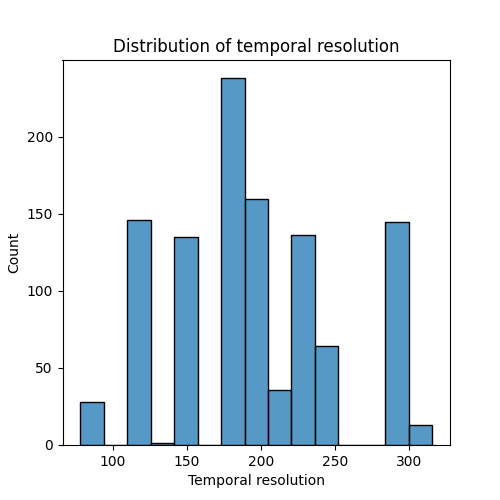

In [143]:
myImage = Image.open("time_fig.png")
myImage

In [11]:
fMRI_dir = os.path.join(os.getcwd(), 'func_ABIDE') # subdirectory containing fMRI data

In [4]:
time_stage = AddFileNames('pheno_clean.csv','phenotype_files') # create new instance of AddFileNames module

In [5]:
t_stage_df = time_stage.df

In [6]:
fmri_files = t_stage_df['FMRI_FILES']

In [12]:
times = []
for i in range(len(fmri_files)):
    x = os.path.join(fMRI_dir, fmri_files[i])
    y = nib.load(x)
    dim = y.shape
    times.append(dim[-1])

low_indexes = []
for i, time in enumerate(times):
    if times[i] < 116:
        low_indexes.append(i)

In [159]:
len(fmri_files)

1102

In [16]:
t_stage_df.loc[low_indexes] # The data with low temporal resolution

,Unnamed: 0,SITE_ID,X,SUB_ID,FILE_ID,AGE_AT_SCAN,SEX,DSM_IV_TR,DX_GROUP,FMRI_FILES,CC200
93,93,OHSU,94,50142,OHSU_0050142,13.99,1,-9999,1,OHSU_0050142_func_preproc.nii.gz,OHSU_0050142_rois_cc200.1D
94,94,OHSU,95,50143,OHSU_0050143,13.79,1,-9999,1,OHSU_0050143_func_preproc.nii.gz,OHSU_0050143_rois_cc200.1D
95,95,OHSU,96,50144,OHSU_0050144,10.22,1,-9999,1,OHSU_0050144_func_preproc.nii.gz,OHSU_0050144_rois_cc200.1D
96,96,OHSU,97,50145,OHSU_0050145,10.75,1,-9999,1,OHSU_0050145_func_preproc.nii.gz,OHSU_0050145_rois_cc200.1D
97,97,OHSU,98,50146,OHSU_0050146,8.00,1,-9999,1,OHSU_0050146_func_preproc.nii.gz,OHSU_0050146_rois_cc200.1D
98,98,OHSU,99,50147,OHSU_0050147,11.35,1,-9999,1,OHSU_0050147_func_preproc.nii.gz,OHSU_0050147_rois_cc200.1D
99,99,OHSU,100,50148,OHSU_0050148,12.65,1,-9999,1,OHSU_0050148_func_preproc.nii.gz,OHSU_0050148_rois_cc200.1D
100,100,OHSU,101,50149,OHSU_0050149,12.32,1,-9999,1,OHSU_0050149_func_preproc.nii.gz,OHSU_0050149_rois_cc200.1D
101,101,OHSU,102,50150,OHSU_0050150,9.42,1,-9999,1,OHSU_0050150_func_preproc.nii.gz,OHSU_0050150_rois_cc200.1D
102,102,OHSU,103,50152,OHSU_0050152,9.73,1,-9999,1,OHSU_0050152_func_preproc.nii.gz,OHSU_0050152_rois_cc200.1D


In [17]:
t_stage_df.drop(low_indexes, inplace=True) # Drop the rows with low temporal resolution

In [20]:
t_stage_df.reset_index(inplace= True, drop=True)# reset index

In [24]:
save_path = os.path.join(time_stage.pheno_dir, 'pheno_clean.csv') # path for saving df as csv

In [25]:
t_stage_df.to_csv(save_path) # save altered dataframe as csv

## Adding pickle filenames containing DFC data

In [26]:
dfc_add = AddFileNames('pheno_clean.csv','phenotype_files')

In [28]:
dfc_add.df

,Unnamed: 0.1,Unnamed: 0,SITE_ID,X,SUB_ID,FILE_ID,AGE_AT_SCAN,SEX,DSM_IV_TR,DX_GROUP,FMRI_FILES,CC200
0,0,0,PITT,1,50002,Pitt_0050002,16.77,1,1,1,Pitt_0050002_func_preproc.nii.gz,Pitt_0050002_rois_cc200.1D
1,1,1,PITT,2,50003,Pitt_0050003,24.45,1,1,1,Pitt_0050003_func_preproc.nii.gz,Pitt_0050003_rois_cc200.1D
2,2,2,PITT,3,50004,Pitt_0050004,19.09,1,1,1,Pitt_0050004_func_preproc.nii.gz,Pitt_0050004_rois_cc200.1D
3,3,3,PITT,4,50005,Pitt_0050005,13.73,2,1,1,Pitt_0050005_func_preproc.nii.gz,Pitt_0050005_rois_cc200.1D
4,4,4,PITT,5,50006,Pitt_0050006,13.37,1,1,1,Pitt_0050006_func_preproc.nii.gz,Pitt_0050006_rois_cc200.1D
...,...,...,...,...,...,...,...,...,...,...,...,...
1069,1069,1097,SBL,1108,51583,SBL_0051583,35.00,1,2,1,SBL_0051583_func_preproc.nii.gz,SBL_0051583_rois_cc200.1D
1070,1070,1098,SBL,1109,51584,SBL_0051584,49.00,1,2,1,SBL_0051584_func_preproc.nii.gz,SBL_0051584_rois_cc200.1D
1071,1071,1099,SBL,1110,51585,SBL_0051585,27.00,1,1,1,SBL_0051585_func_preproc.nii.gz,SBL_0051585_rois_cc200.1D
1072,1072,1100,MAX_MUN,1111,51606,MaxMun_a_0051606,29.00,2,2,1,MaxMun_a_0051606_func_preproc.nii.gz,MaxMun_a_0051606_rois_cc200.1D


In [29]:
dfc_add.add_feature('DFC_DATA_STORE', 'dfc_cc200','.pkl')# add pickle files containing DFC data dictionaries

,Unnamed: 0.1,Unnamed: 0,SITE_ID,X,SUB_ID,FILE_ID,AGE_AT_SCAN,SEX,DSM_IV_TR,DX_GROUP,FMRI_FILES,CC200,DFC_DATA_STORE
0,0,0,PITT,1,50002,Pitt_0050002,16.77,1,1,1,Pitt_0050002_func_preproc.nii.gz,Pitt_0050002_rois_cc200.1D,Pitt_0050002_dfc.pkl
1,1,1,PITT,2,50003,Pitt_0050003,24.45,1,1,1,Pitt_0050003_func_preproc.nii.gz,Pitt_0050003_rois_cc200.1D,Pitt_0050003_dfc.pkl
2,2,2,PITT,3,50004,Pitt_0050004,19.09,1,1,1,Pitt_0050004_func_preproc.nii.gz,Pitt_0050004_rois_cc200.1D,Pitt_0050004_dfc.pkl
3,3,3,PITT,4,50005,Pitt_0050005,13.73,2,1,1,Pitt_0050005_func_preproc.nii.gz,Pitt_0050005_rois_cc200.1D,Pitt_0050005_dfc.pkl
4,4,4,PITT,5,50006,Pitt_0050006,13.37,1,1,1,Pitt_0050006_func_preproc.nii.gz,Pitt_0050006_rois_cc200.1D,Pitt_0050006_dfc.pkl
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,1069,1097,SBL,1108,51583,SBL_0051583,35.00,1,2,1,SBL_0051583_func_preproc.nii.gz,SBL_0051583_rois_cc200.1D,SBL_0051583_dfc.pkl
1070,1070,1098,SBL,1109,51584,SBL_0051584,49.00,1,2,1,SBL_0051584_func_preproc.nii.gz,SBL_0051584_rois_cc200.1D,SBL_0051584_dfc.pkl
1071,1071,1099,SBL,1110,51585,SBL_0051585,27.00,1,1,1,SBL_0051585_func_preproc.nii.gz,SBL_0051585_rois_cc200.1D,SBL_0051585_dfc.pkl
1072,1072,1100,MAX_MUN,1111,51606,MaxMun_a_0051606,29.00,2,2,1,MaxMun_a_0051606_func_preproc.nii.gz,MaxMun_a_0051606_rois_cc200.1D,MaxMun_a_0051606_dfc.pkl


In [32]:
pkl_df = dfc_add.df

In [33]:
save_path = os.path.join(dfc_add.pheno_dir, 'pheno_clean.csv')  # path for saving df as csv
pkl_df.to_csv(save_path)  # save altered dataframe as csv